In [2]:
import sys
sys.path.append('/home/nvidia/dev_rmstudio/lib')

import numpy as np
import open3d
import time
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
    
import rmlib
rm = rmlib.RMLib()

Robot Ready


In [16]:
rm.open_gripper()

1

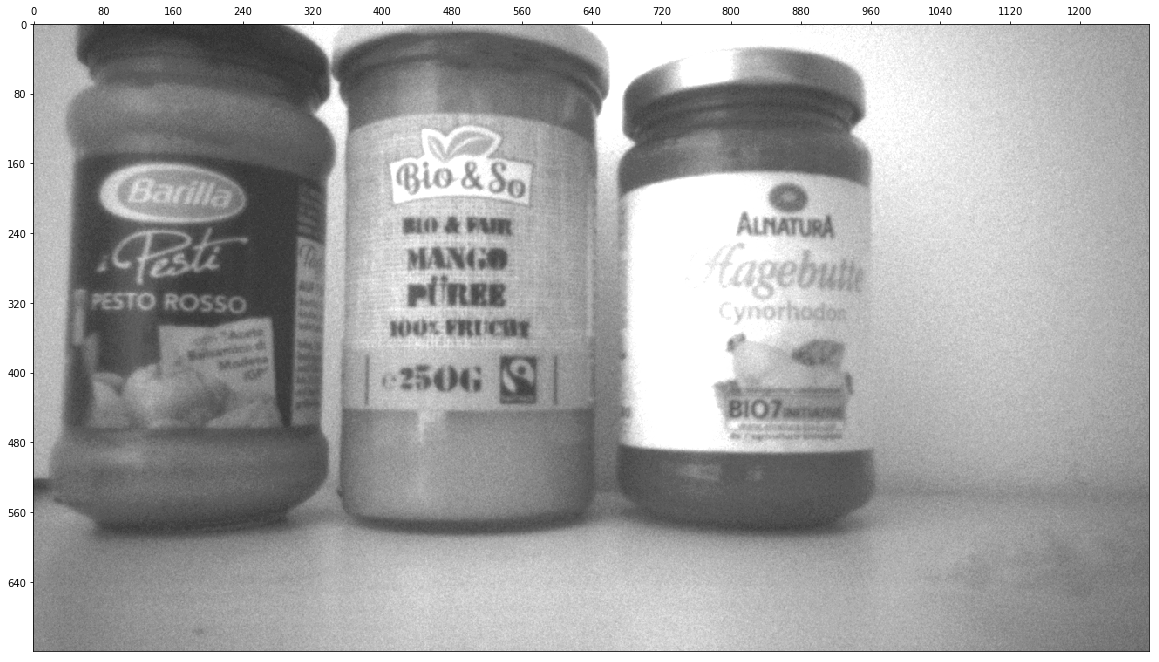

In [13]:
# Run this to take a new snapshot from the camera (don't run if you want to use a canned one)
rm.set_laser_state(False)
rm.set_auto_exposure_on(True)
#rm.set_exposure(165000)

img = rm.get_ir_image()
img = cv2.flip(img,0)
img = cv2.flip(img,1)
img = np.array(img*255./img.max()).astype(np.uint8)

cv2.imwrite('data/snapshot.png',img)

view = rm.IR_Viewer()
view.add_image(img)
view.show()

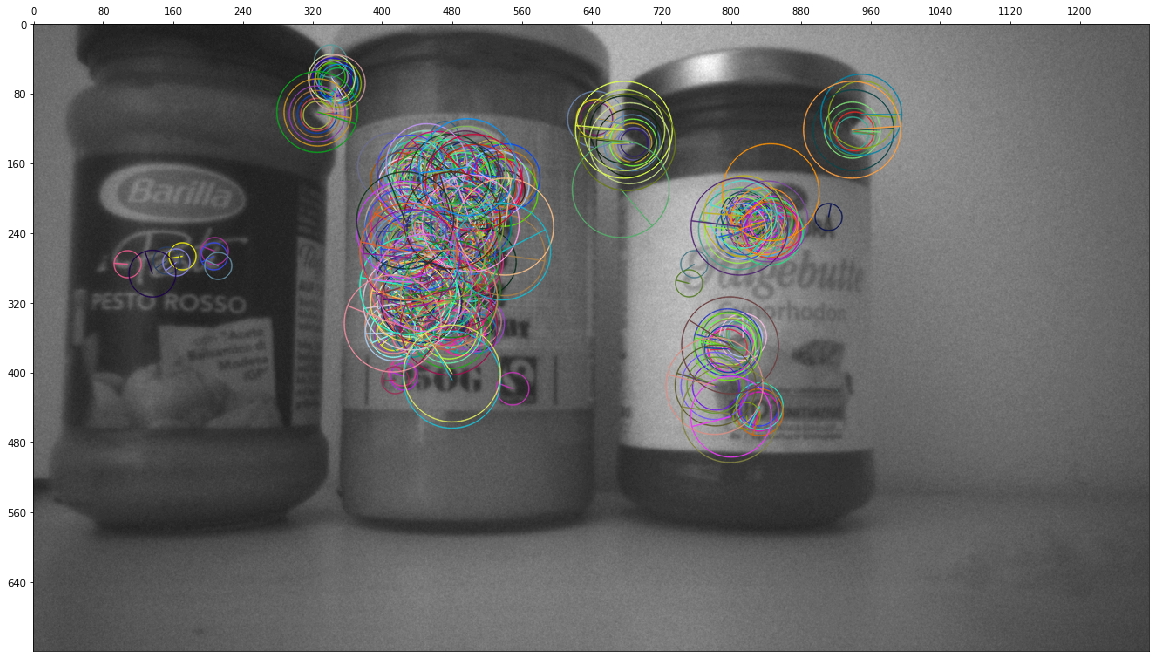

In [14]:
orb = cv2.ORB_create()
key_points, description = orb.detectAndCompute(img, None)
img_keypoints = cv2.drawKeypoints(img, 
                                key_points, 
                                img, 
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
view = rm.IR_Viewer()
view.add_image(img_keypoints)
view.show()

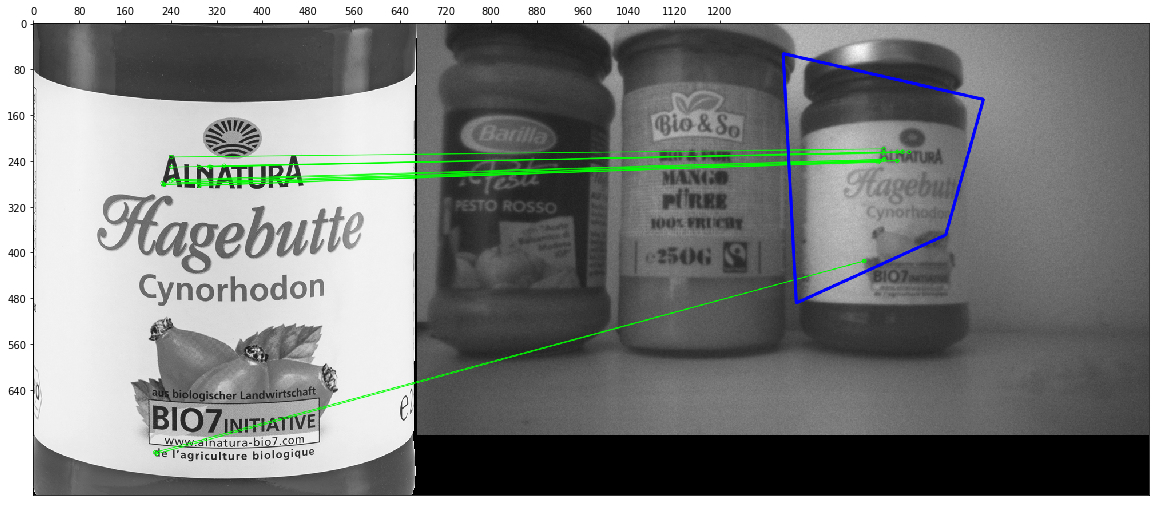

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('data/hagebutte.png', 0).astype(np.uint8)
#img2 = img
img2 = cv2.imread('data/snapshot.png', 0).astype(np.uint8)

# Initiate SIFT detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

good_matches = matches[:100]

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches     ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

dst = cv2.perspectiveTransform(pts,M)
dst += (w, 0)  # adding offset

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
               singlePointColor = None,
               matchesMask = matchesMask, # draw only inliers
               flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches, None,**draw_params)

img3 = cv2.polylines(img3, [np.int32(dst)], True, (0,0,255),3, cv2.LINE_AA)

view = rm.IR_Viewer()
view.add_image(img3)
view.show()